Two agent case, logit demand. But instead of picking pricies directly, both agents use Q learning. The state space is the 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from env.LogitDemandPricingEnv import LogitDemandPricingEnv
np.random.seed(42)
import os
FIGURE_DIR = "./figure"
DATA_DIR = "./data"

In [2]:
class QLearningAgent:
    """
    Q-learning agent for the duopoly‐logit pricing game.
      - State s_t = price index played in previous round (0…n_actions-1).
      - Action a_t ∈ {0…n_actions-1} picks the next price index.
      - Greedy policy: always pick argmax_a Q[s, a].
    """
    def __init__(
        self,
        n_actions: int,
        alpha: float = 0.1,
        gamma: float = 0.9,
        init_low: float = 10.0,
        init_high: float = 20.0,
        cost: float = 2.0,
        prices: np.ndarray = None,
    ):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.t = 0 # time step
        self.omega = 1.5e-5
        self.cost = cost
        self.prices = prices  # array of actual price values
        # Q-table: rows = states (previous price idx), cols = actions (next price idx)
        self.Q = np.random.uniform(init_low, init_high, size=(n_actions**2, n_actions))

    def take_action(self, state: int) -> int:
        """epsilon-Greedy: epsilon = exp(-t * omega)"""
        epsilon = np.exp(-self.t * self.omega)
        if np.random.rand() < epsilon:
            # Explore: pick random action
            action = np.random.randint(self.n_actions)
        else:
            # Exploit: pick best action according to Q-table
            action = int(np.argmax(self.Q[state]))
        return action

    def update(self, state: int, action: int, reward: float, next_state: int):
        """One‐step Q‐learning update."""
        best_next = np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error
        # update the time step
        self.t += 1
    
# A function to convert joint action (i,j) to index in Q-table  
def joint_to_index(i, j, grid_size):
    """Convert joint action (i,j) to index in Q-table."""
    return i * grid_size + j


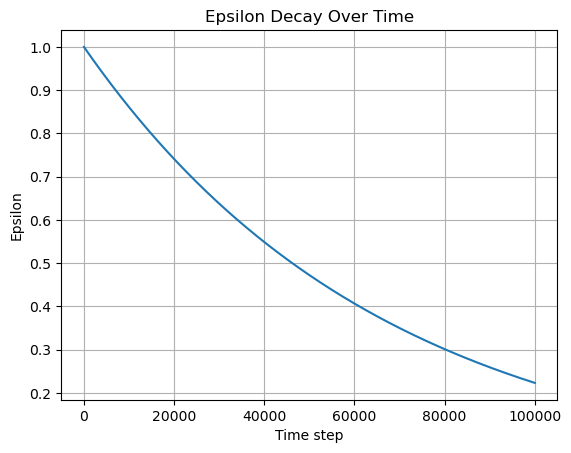

In [3]:
func = lambda t: np.exp(-t * 1.5e-5)
def plot_epsilon_decay():
    """Plot epsilon decay over time."""
    t = np.arange(0, 100000, 1)
    epsilon = func(t)
    plt.plot(t, epsilon)
    plt.xlabel('Time step')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Time')
    plt.grid()
    plt.show()
plot_epsilon_decay()

In [4]:
def simulate_QpQp(env, periods, alpha=0.1, gamma=0.9):
    """
    Run a Q-learning vs. Q-learning price competition for `periods` steps.
    
    Returns
    -------
    history : np.ndarray, shape (periods,)
        The time series of firm 1's chosen prices.
    """
    # --- 1) Create two agents with fresh Q‐tables
    n_actions = len(env.prices)
    agent0 = QLearningAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        prices=env.prices,
        cost=env.cost
    )
    agent1 = QLearningAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        prices=env.prices,
        cost=env.cost
    )
    # print(f"Q-table shape: {agent0.Q.shape}") 
    

    history0 = np.zeros(periods)
    history1 = np.zeros(periods)
    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)

    # --- 2) Initialize environment & states
    # Gymnasium reset returns (obs, info)
    (obs_0, obs_1), info = env.reset()
    state0 = joint_to_index(obs_0, obs_1, n_actions)
    state1 = joint_to_index(obs_0, obs_1, n_actions)

    # --- 3) Main loop
    for t in range(periods):
        # each agent picks greedily by Q
        a0 = agent0.take_action(state0)
        a1 = agent1.take_action(state1)

        # step the env; unpack according to Gymnasium API
        (next_obs_0, next_obs_1), (r1, r2), terminated, truncated, info = env.step((a0, a1))
        # print(f"Firm 0: {env.prices[a0]}, Firm 1: {env.prices[a1]}")
        # print(f"Rewards: {r1}, {r2}")
        # print(f"Next obs: {next_obs_0}, {next_obs_1}")
        # print(f"Next state: {joint_to_index(next_obs_0, next_obs_1, n_actions)}")
        # print(f"State: {state0}, {state1}")

        # map next observations to next states
        next_state0 = joint_to_index(next_obs_0, next_obs_1, n_actions)
        next_state1 = joint_to_index(next_obs_0, next_obs_1, n_actions)

        # Q‐learning updates
        agent0.update(state0, a0, r1, next_state0)
        agent1.update(state1, a1, r2, next_state1)

        # record firm 0’s actual price
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1]

        # record firm 0’s action
        history_action_0[t] = a0
        history_action_1[t] = a1
        # record firm 0’s profit
        history_profit_0[t] = r1
        history_profit_1[t] = r2
        # roll over state
        obs_0, obs_1 = next_obs_0, next_obs_1
        state0, state1 = next_state0, next_state1

        # optionally break if episode ends
        if terminated or truncated:
            break

    return history0, history_action_0, history_profit_0


def move_average(x, window):
    """Compute moving average of x with window size."""
    return np.convolve(x, np.ones(window), 'valid') / window

def plot_percentiles(percentiles, periods, title, save_path=None, ne_price=None, mono_price=None):
    """
    Plot min, 25th, median, 75th, and max percentile lines.
    percentiles shape = (5, periods).
    Plot the monopoly price and Nash equilibrium price if provided as dashed lines.
    """
    window = 300
    x = np.arange(periods-window+1)
    labels_linestyle = [
        ('Min',           '-'),
        ('25th percentile','--'),
        ('Median',        '-'),
        ('75th percentile','--'),
        ('Max',           '-'),
    ]
    plt.figure(figsize=(10, 4))
    for idx, (label, ls) in enumerate(labels_linestyle):
        lw = 2 if label == 'Median' else 1
        # moving ave
        move_ave_pct = move_average(percentiles[idx], window=window)
        plt.plot(x, move_ave_pct, linestyle=ls, linewidth=lw, label=label)
    # plot monopoly price
    if ne_price is not None:
        plt.axhline(y=ne_price, color='grey', linestyle='--', label='Competitive Price (NE)')
    if mono_price is not None:
        plt.axhline(y=mono_price, color='grey', linestyle='--', label='Monopoly Price')
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def simulate_batch(periods, runs, alpha, gamma, env, simfunc):
    """
    Run `runs` simulations in batch.

    Returns
    -------
    history1_all         : np.ndarray, shape (runs, periods)
        The time series of firm 1's chosen prices for each run.
    history_action_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's actions for each run. Here is the rule index.
    history_profit_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's profits for each run.
    """
    history1_all = []
    history_action_1_all = []
    history_profit_1_all = []

    for _ in range(runs):
        h1, ha1, hp1 = simfunc(env, periods, alpha, gamma)
        history1_all.append(h1)
        history_action_1_all.append(ha1)
        history_profit_1_all.append(hp1)

    return (
        np.array(history1_all),         # shape (runs, periods)
        np.array(history_action_1_all),
        np.array(history_profit_1_all)
    )

def save_simulation_results(price_hist, action_hist, profit_hist, file_prefix, data_dir="DATA_DIR"):
    """
    Save simulation results of price, action, and profit histories to CSV files.

    Parameters:
    - price_hist (ndarray): Array of shape (runs, periods) for price history.
    - action_hist (ndarray): Array of shape (runs, periods) for action history.
    - profit_hist (ndarray): Array of shape (runs, periods) for profit history.
    - file_prefix (str): Prefix for output CSV filenames (e.g., 'q-learning-vs-q-learning-rule-price-competition').
    - data_dir (str): Directory where CSVs are saved.
    """

    run = price_hist.shape[0]

    df_price = pd.DataFrame(price_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_action = pd.DataFrame(action_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_profit = pd.DataFrame(profit_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])

    os.makedirs(data_dir, exist_ok=True)
    df_price.to_csv(os.path.join(data_dir, f"{file_prefix}-price.csv"), index=False)
    df_action.to_csv(os.path.join(data_dir, f"{file_prefix}-action.csv"), index=False)
    df_profit.to_csv(os.path.join(data_dir, f"{file_prefix}-profit.csv"), index=False)

    print(f"Simulation complete. Data saved to CSV files with prefix '{file_prefix}'.")

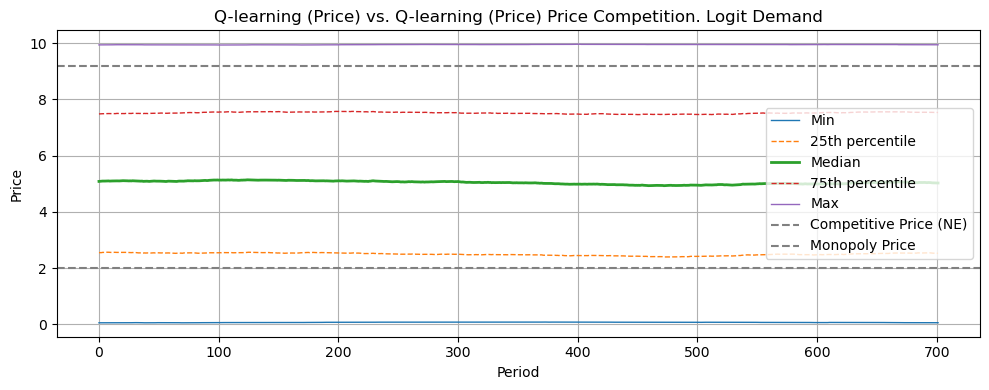

In [ ]:
# Run the simulation
run = 50
periods = 600_000 # need to increase to 90,0000 if we need 100 grids.
# periods = 1001
alpha = 0.15
gamma = 0.9
env = LogitDemandPricingEnv(
    price_min = 0.01,
    price_max = 10.0,
    grid_size = 25,
    marginal_cost = 2.0,
    beta = 0.95,
    a_0=0, # parameter for logit demand. OUtside option
    a_12=10, # parameter for logit demand. Inside option
    mu = 0.25 # parameter for logit demand. Vertical differentiation
)

# Calculate monopoly price and NE price
# Monopoly Price
func_mono_profit = lambda p: (p - env.cost) * (np.exp((env.a_12 - p) / env.mu) / (np.exp((env.a_12 - p) / env.mu) + np.exp((env.a_0) / env.mu)))
p_mono = minimize_scalar(lambda p: -func_mono_profit(p), bounds=(env.price_min, env.price_max), method='bounded').x
p_mono = np.round(p_mono, 2)
# Competitive Price
def func_nash_equilibrium(p_i, p_j):
    d_i = np.exp((env.a_12 - p_i) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    d_j = np.exp((env.a_12 - p_j) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    return (p_i - env.cost) * d_i, (p_j - env.cost) * d_j
def equations(p):
    p_i, p_j = p
    return func_nash_equilibrium(p_i, p_j)
p_nash = fsolve(equations, (env.price_min, env.price_min))[0]

batch = simulate_batch(
    periods=periods,
    runs=run,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QpQp
)

price_hist, action_hist, profit_hist = batch

pc = np.percentile(price_hist, [0, 25, 50, 75, 100], axis=0)
plot_percentiles(
    percentiles=pc,
    periods=periods,
    title="Q-learning (Price) vs. Q-learning (Price) Price Competition. Logit Demand",
    save_path=os.path.join(FIGURE_DIR, "q-learning-vs-q-learning.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

In [ ]:
# save the price history
save_simulation_results(
    price_hist=price_hist[:,-1000:],
    action_hist=action_hist[:,-1000:],
    profit_hist=profit_hist[:,-1000:],
    file_prefix="q-learning-price-vs-q-learning-price-competition",
    data_dir=DATA_DIR
)

Simulation complete. Data saved to CSV files with prefix 'q-learning-price-vs-q-learning-price-competition'.
